In [1]:
! ls

'app (copy).ipynb'   ChitoAtlAGG.txt	 LAtoDenvAGG.txt   SeatoDenvAGG.txt
 app.ipynb	     DaltoDenvAGG.txt	 MiatoAtlAGG.txt
 AtltoDalAGG.txt     DenvtoMinnAGG.txt	 NYtoAtlAGG.txt


In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch_geometric
from torch.nn import Linear, Module, BatchNorm1d, ReLU, Dropout, MSELoss, ModuleList, LSTM, L1Loss
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch.optim import Adam

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
seed = 42
import random
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Data

## Flow

In [5]:
import os 
# device = 'cpu'
flows = []
for file in os.listdir()[:-1]:
    if file.endswith('.txt'):
        flow = pd.read_csv(file).values[:, -1]
        print(file)
        print(flow.shape)
        flows.append(flow)

flows = torch.from_numpy(np.stack(flows)).float()
# flows = torch.log2(flows + 1)
flows /= 1e6
    

SeatoDenvAGG.txt
(150,)
DenvtoMinnAGG.txt
(150,)
ChitoAtlAGG.txt
(150,)
LAtoDenvAGG.txt
(150,)
AtltoDalAGG.txt
(150,)
DaltoDenvAGG.txt
(150,)
NYtoAtlAGG.txt
(150,)
MiatoAtlAGG.txt
(150,)


In [6]:
flows.shape

torch.Size([8, 150])

## Graph

In [7]:
# device = 'cpu'
edge_index = torch.tensor([[0, 1, 1, 2, 0, 2, 4, 2, 3, 2, 3, 4, 3, 5, 6, 6, 5, 4, 7, 4, 7, 6, 5, 8, 6, 8],
                           [1, 0, 2, 1, 2, 0, 2, 4, 2, 3, 4, 3, 5, 3, 5, 6, 4, 6, 4, 7, 6, 7, 8, 5, 8, 6]], dtype=torch.long)
x = torch.tensor([[1], [1], [1], [1], [1], [1], [1], [1], [1]], dtype=torch.float)

data = Data(x=x.to(device), edge_index=edge_index.to(device), flows=flows.to(device))


# Model

In [8]:
def train(st, data, time, loss_fn, optimizer):
    st.train()

    optimizer.zero_grad()

    output = st(data, time)

    loss = loss_fn(output, data.flows[:, time])

    loss.backward()

    optimizer.step()

    return loss.item()
    

In [9]:
@torch.no_grad()
def eval(st, data, times):
    st.eval()

    errors = []
    for time in times:
        output = st(data, time)
        error = L1Loss()(output, data.flows[:, time])
        errors.append(error)
        # print(output, data.flows[:, time])
        
    return torch.tensor(errors).mean()

In [10]:
class SpatioTemporal(Module):
    def __init__(self, input_dim, gnn_dims, node_pooling_dims, graph_pooling_dims, rnn_dim, ff_dims, gnn_dropout_rate, ff_dropout_rate, rnn_dropout_rate):
        super(SpatioTemporal, self).__init__()
        self.input_dim = input_dim
        self.gnn_dims = gnn_dims
        self.node_pooling_dims = node_pooling_dims
        self.graph_pooling_dims = graph_pooling_dims
        self.rnn_dim = rnn_dim
        self.ff_dims = ff_dims
        self.gnn_dropout_rate = gnn_dropout_rate
        self.ff_dropout_rate = ff_dropout_rate
        self.rnn_dropout_rate = rnn_dropout_rate

        ## GNN
        dims = [self.input_dim] + gnn_dims
        self.gnn_layers = ModuleList(
            [
               GCNConv(dim, dims[i+1]) for i, dim in enumerate(dims[:-1])
            ]
        )

        self.gnn_bn_layers = ModuleList(
            [
               BatchNorm1d(dim) for dim in dims[1:]
            ]
        )

        ## Node Pooling
        dims = [self.gnn_dims[-1]] + self.node_pooling_dims
        self.node_pooling_layers = ModuleList(
            [
               Linear(dim, dims[i+1]) for i, dim in enumerate(dims[:-1])
            ]
        )

        self.node_pooling_bn_layers = ModuleList(
            [
               BatchNorm1d(dim) for dim in dims[1:]
            ]
        )

        ## Graph Pooling
        dims = [self.node_pooling_dims[-1]] + self.graph_pooling_dims
        self.graph_pooling_layers = ModuleList(
            [
               Linear(dim, dims[i+1]) for i, dim in enumerate(dims[:-1])
            ]
        )

        ## RNN
        self.rnn = LSTM(self.graph_pooling_dims[-1] + self.ff_dims[-1], self.rnn_dim, 2, dropout=self.rnn_dropout_rate)


        dims = [self.rnn_dim] + self.ff_dims
        self.ff_layers = ModuleList(
            [
               Linear(dim, dims[i+1]) for i, dim in enumerate(dims[:-1])
            ]
        )

        self.activation = ReLU()
        self.gnn_dropout = Dropout(self.gnn_dropout_rate)
        self.ff_dropout = Dropout(self.ff_dropout_rate)

    def forward(self, data, timestep):
        x = data.x

        # GNN
        for conv, bn in zip(self.gnn_layers, self.gnn_bn_layers):
            
            x = conv(x, edge_index=data.edge_index)
            x = bn(x)
            x = self.activation(x)
            x = self.gnn_dropout(x)
        
        # Node Pooling 
        for ff, bn in zip(self.node_pooling_layers, self.node_pooling_bn_layers):
            x = ff(x)
            x = bn(x)
            x = self.activation(x)
            x = self.ff_dropout(x) 
        
        x = x.sum(0).reshape(1, -1)

        # Graph Pooling 
        for ff in self.graph_pooling_layers:
            x = ff(x)
            # x = bn(x)
            x = self.activation(x)
            x = self.ff_dropout(x) 

        # RNN
        x = x.repeat(timestep + 1, 1)

        global device
        x_time = torch.hstack((torch.zeros(flows.shape[0]).reshape(-1, 1).to(device), data.flows[:, :timestep])).t()

        x = torch.hstack((x_time, x))
        
        x, (h, c) = self.rnn(x)
        
        # Regression
        x = x[-1, :]
        for ff in self.ff_layers[:-1]:
            x = ff(x)
            # x = bn(x)
            x = self.activation(x)
            x = self.ff_dropout(x)
        
        x = self.ff_layers[-1](x)
        
        return self.ff_dropout(x).reshape(-1)



# Training

In [11]:
def pipeline_for_one_config(st, data, loss_fn, optimizer):
    train_errors = []
    val_errors = []
    test_errors = []
    train_errors.append(eval(st, data, range(1, 80)))
    val_errors.append(eval(st, data, range(81, 105)))
    test_errors.append(eval(st, data, range(106, 130)))

    for epoch in range(100):
        train_errors.append(eval(st, data, range(1, 80)))
        val_errors.append(eval(st, data, range(81, 105)))
        test_errors.append(eval(st, data, range(106, 130)))

        epoch_loss = 0
        for time in range(1, 80):
            epoch_loss += train(st, data, time, loss_fn, optimizer)
        # if epoch % 5 == 0:
        #     print(f'Epoch {epoch + 1}') 
        #     print(f'Train Loss: {epoch_loss / 80 :.3f}')
        #     print(f'Train Error: {eval(st, data, range(1, 80)).item(): .2f}')
        #     print(f'Validation Error: {eval(st, data, range(81, 105)).item(): .2f}')
        #     print(f'Test Error: {eval(st, data, range(106, 130)).item() :.2f}')   
        #     print('===============================')
    train_errors.append(eval(st, data, range(1, 80)))
    val_errors.append(eval(st, data, range(81, 105)))
    test_errors.append(eval(st, data, range(106, 130)))

    i = torch.tensor(val_errors).argmin()
    return val_errors[i], test_errors[i]

In [12]:
gnn_dims = [32, 64, 128]
node_pooling_dims = [64, 160]
graph_pooling_dims = [80, 200]
rnn_dims = [100, 384]
ff_dims = [128, 300]
dropout = [0.03, 0.1, 0.2, 0.3]
learning_rates = [1e-4, 1e-3]

In [124]:

from itertools import product
devs = []
tests = []
configs = product(gnn_dims, node_pooling_dims, graph_pooling_dims, rnn_dims, ff_dims, dropout, learning_rates)
for gnn_dim, np_dim, gp_dim, rnn_dim, ff_dim, dropout, lr in configs:
    st = SpatioTemporal(1, [gnn_dim, gnn_dim], [np_dim, np_dim], [gp_dim, gp_dim], rnn_dim, [ff_dim, 8], dropout, dropout, dropout).to(device)
    optimizer = Adam(st.parameters(), lr=lr)
    loss_fn = MSELoss()
    dev_error, test_error = pipeline_for_one_config(st, data, loss_fn, optimizer)
    print(gnn_dim, np_dim, gp_dim, rnn_dim, ff_dim, dropout, lr)
    print(dev_error /  flows[:, 81: 105].numpy().mean())
    print(test_error / flows[:, 106: 130].numpy().mean())
    devs.append(dev_error)
    tests.append(test_error)
    print('-----------------------------------------')

32 64 80 100 128 0.03 0.0001
tensor(0.3432)
tensor(0.2611)
-----------------------------------------
32 64 80 100 128 0.03 0.001
tensor(0.4477)
tensor(0.2236)
-----------------------------------------
32 64 80 100 128 0.1 0.0001
tensor(0.3698)
tensor(0.4081)
-----------------------------------------
32 64 80 100 128 0.1 0.001
tensor(0.3169)
tensor(0.2309)
-----------------------------------------
32 64 80 100 128 0.2 0.0001
tensor(0.3652)
tensor(0.4083)
-----------------------------------------
32 64 80 100 128 0.2 0.001
tensor(0.3273)
tensor(0.2543)
-----------------------------------------
32 64 80 100 128 0.3 0.0001
tensor(0.3260)
tensor(0.3718)
-----------------------------------------
32 64 80 100 128 0.3 0.001
tensor(0.3141)
tensor(0.2404)
-----------------------------------------
32 64 80 100 300 0.03 0.0001
tensor(0.3658)
tensor(0.2819)
-----------------------------------------
32 64 80 100 300 0.03 0.001
tensor(0.4177)
tensor(0.2107)
-----------------------------------------
3

In [140]:
i = torch.tensor(devs).argmin()
configs = product(gnn_dims, node_pooling_dims, graph_pooling_dims, rnn_dims, ff_dims, dropout, learning_rates)
devs[i]/  flows[:, 81: 105].numpy().mean(), tests[i]/  flows[:, 106: 130].numpy().mean(), list(configs)[i]

(tensor(0.2685), tensor(0.2975), (32, 160, 80, 384, 300, 0.3, 0.0001))

In [15]:
# 32 160 80 384 300 0.3 0.0001
# tensor(0.2685)
# tensor(0.2975)
gnn_dim = 32
np_dim = 160
gp_dim = 80
rnn_dim = 384
ff_dim = 300
dropout = 0.3
lr = 1e-4

In [18]:
devs = []
tests = []

st = SpatioTemporal(1, [gnn_dim, gnn_dim], [np_dim, np_dim], [gp_dim, gp_dim], rnn_dim, [ff_dim, 8], dropout, dropout, dropout).to(device)
optimizer = Adam(st.parameters(), lr=lr)
loss_fn = MSELoss()


train_errors = []
val_errors = []
test_errors = []
train_errors.append(eval(st, data, range(1, 80)))
val_errors.append(eval(st, data, range(81, 105)))
test_errors.append(eval(st, data, range(106, 130)))

for epoch in range(100):
    train_errors.append(eval(st, data, range(1, 80)))
    val_errors.append(eval(st, data, range(81, 105)))
    test_errors.append(eval(st, data, range(106, 130)))

    epoch_loss = 0
    for time in range(1, 80):
        epoch_loss += train(st, data, time, loss_fn, optimizer)
    if epoch % 1 == 0:
        print(f'Epoch {epoch + 1}') 
        print(f'Train Loss: {epoch_loss / 80 :.3f}')
        print(f'Train Error: {eval(st, data, range(1, 80)).item(): .2f}')
        print(f'Validation Error: {eval(st, data, range(81, 105)).item(): .2f}')
        print(f'Test Error: {eval(st, data, range(106, 130)).item() :.2f}')   
        print('===============================')
train_errors.append(eval(st, data, range(1, 80)))
val_errors.append(eval(st, data, range(81, 105)))
test_errors.append(eval(st, data, range(106, 130)))

Epoch 1
Train Loss: 24.799
Train Error:  1.90
Validation Error:  2.05
Test Error: 3.22
Epoch 2
Train Loss: 14.756
Train Error:  1.83
Validation Error:  1.94
Test Error: 3.17
Epoch 3
Train Loss: 12.898
Train Error:  1.75
Validation Error:  1.90
Test Error: 3.04
Epoch 4
Train Loss: 16.110
Train Error:  1.75
Validation Error:  1.91
Test Error: 3.04
Epoch 5
Train Loss: 14.983
Train Error:  1.76
Validation Error:  1.90
Test Error: 3.05
Epoch 6
Train Loss: 12.438
Train Error:  1.79
Validation Error:  1.91
Test Error: 3.09
Epoch 7
Train Loss: 15.000
Train Error:  1.77
Validation Error:  1.90
Test Error: 3.05
Epoch 8
Train Loss: 15.527
Train Error:  1.76
Validation Error:  1.88
Test Error: 3.00
Epoch 9
Train Loss: 14.444
Train Error:  1.80
Validation Error:  1.91
Test Error: 3.10
Epoch 10
Train Loss: 13.970
Train Error:  1.80
Validation Error:  1.91
Test Error: 3.09
Epoch 11
Train Loss: 16.204
Train Error:  1.82
Validation Error:  1.93
Test Error: 3.11
Epoch 12
Train Loss: 15.902
Train Error: 

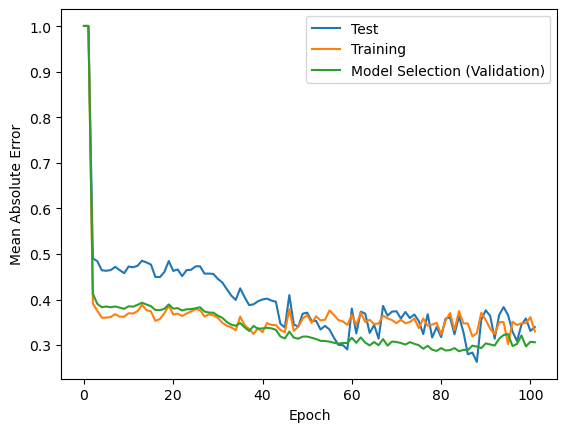

In [19]:
a = np.array(test_errors) / flows[:, 106: 130].numpy().mean()
b = np.array(train_errors) / flows[:, 1: 80].numpy().mean()
c = np.array(val_errors) / flows[:, 81: 105].numpy().mean()
plt.plot(np.arange(len(test_errors)), a)
plt.plot(np.arange(len(test_errors)), b)
plt.plot(np.arange(len(test_errors)), c)

plt.legend(['Test', 'Training', 'Model Selection (Validation)'])
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.show()